# Single atom training
This notebook goes through the workflow of setting the hyperparameters, collecting atom manipulation data, and training the deep reinforcement learning agent.

### Importing modules

cpu
succeed to connect
succeed to connect
manipulation limit: [-157.77302551 -148.27302551 -294.40299416 -284.90299416]
Load cnn weight


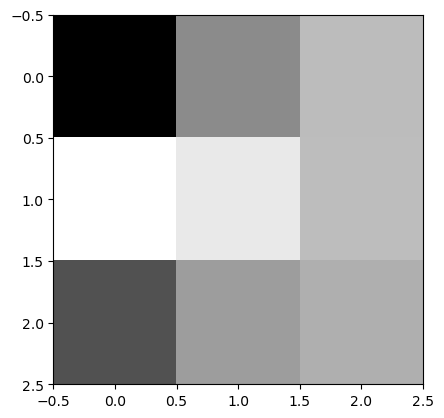

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from collections import deque, namedtuple
from matplotlib import pyplot as plt, patches
import torch
from REACTRL import DissociateEnv, RealExpEnv, Episode_Memory, Createc_Controller, sac_agent, ReplayMemory, HerReplayMemory
from REACTRL import plot_graph, show_reset, show_done, show_step, image_detect_edges, assign_mol_design, mol_property
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
from matplotlib import pyplot as plt, patches

# Python code to demonstrate namedtuple()
from collections import namedtuple

import cv2

import datetime
import pickle

from tqdm import tqdm
from scipy.spatial.distance import cdist


createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
#TODO
#Set the pixel of the top-left corner, widht, and height of the anchor
#If the anchor is not used, just set w and h to a small number like below
top_left, w, h = (0,0), 3, 3
#template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
#plt.imshow(template)

template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)



#TODO
diss_radius_nm = 0.6 #Set the radius of the manipulation start position relative the the atom start position
goal_nm  = 2 #Set the radius of the manipulation end position relative the the atom start position
max_diss_z_nm = 40 #Set the maximum z height in nm
min_diss_z_nm = 20 #Set the minimum z height in nm
max_mvoltage = 3700 #Set the maximum bias voltage in mV 
max_pcurrent = 1200 #Set the maximum conductance in pA/mV
max_len = 5 #Set maximum episode length
template_max_y = 3 #Set the maximum or minimum row number to search for anchor
#Set the path to load CNN weight for the atom movement classifier
# CNN_weight_path = 'C:/Users/wun2/github/reaction_rl/training_data_and_model_parameters/model parameters/_atom_move_detector_conv_2740.pth'
# current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan

CNN_weight_path = 'C:/LocalUserData/User-data/phys-asp-lab/nian_auto_spm/reaction_rl/training_data_and_model_parameters/model parameters/_atom_move_detector_conv_2740.pth'
current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan


#Set STM scan parameters
pixel = 128
im_size_nm = 10 #Image size in nm 
scan_mV = 1000 #bias voltage
x_nm, y_nm = createc_controller.get_offset_nm()
offset_nm = np.array([x_nm, y_nm]) #Set offset to current offset value

#Set manipulation parameters to pull atoms from image edge to center
pull_back_mV = 5 #bias in mV
pull_back_pA = 60000 #current in pA

#Set manipulation limit [left, right, up, down] in nm
manip_limit_nm = np.array([x_nm - 0.5*im_size_nm+0.25, x_nm + 0.5*im_size_nm-0.25, y_nm+0.25, y_nm+im_size_nm-0.25])

env = DissociateEnv(diss_radius_nm=diss_radius_nm,
                    goal_nm=goal_nm,
                    max_diss_z_nm=max_diss_z_nm,
                    min_diss_z_nm=min_diss_z_nm,
                    max_mvoltage=max_mvoltage,
                    max_pcurrent=max_pcurrent,
                    max_len=max_len,
                    template=template,
                    template_max_y=template_max_y,
                    load_weight=CNN_weight_path,
                    current_jump=current_jump,
                    pixel=pixel,
                    im_size_nm=im_size_nm,
                    scan_mV=scan_mV,
                    offset_nm=offset_nm,
                    pull_back_mV=pull_back_mV,
                    pull_back_pA=pull_back_pA,
                    manip_limit_nm=manip_limit_nm,
)


#TODO
batch_size= 128 #Set minibatch size
LEARNING_RATE = 0.0003 #Set learning rate

#Set the action space range
ACTION_SPACE = namedtuple('ACTION_SPACE', ['high', 'low'])
action_space = ACTION_SPACE(high = torch.tensor([1,1,1,1]), low = torch.tensor([-1,-1,1/3,1/2]))

#Initialize the soft actor-critic agent
alpha = 1.0
agent = sac_agent(num_inputs = 4, num_actions = 4, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=alpha)



#TODO
replay_size=1000000 #Set memory size

memory = HerReplayMemory(replay_size, env, strategy = 'future')


episode_memory = Episode_Memory()
#TODO
#Set the folder name to store training data and neural network weight
folder_name =  'C:/LocalUserData/User-data/phys-asp-lab/nian_auto_spm/test_nian'


c_k_min = 500
eta = 0.994
max_ep_len = max_len


episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

max_steps = 10
num_episodes = 500
episode_start = 0


i_episode=0
episode_reward, episode_steps = 0, 0
done = False
check_similarity=None
candidate_mols=None


In [4]:
mol_center_x_nm, mol_center_y_nm, check_similarity, candidate_mols=env.get_state(x_nm=env.createc_controller.get_offset_nm()[0], y_nm=env.createc_controller.get_offset_nm()[1], scan_len_nm_large=20, new_scan_region=True, check_similarity=check_similarity, candidate_mols=candidate_mols,  current_time=None, img_name='abc', data_name='abc')

start tip forming now


In [5]:
i_episode

102

Episode: 102
The scan will take 43.9 seconds
Epoch 102_0 dissociation diff_topography: 0.03 
Epoch 102_0 scan a image after dissociating now....
The scan will take 43.9 seconds
Different prediction shows no dissociation
Epoch 102_0 dissociation diff_topography: 0.03 diff_area 0.11
Different prediction shows no dissociation
start tip forming now
start scanning region: seek_time 1 (-287.99121856689453, 102.99686431884766)
The scan will take 43.9 seconds
candidate_mols [[17.46, 106.52]]
mol num: 0
The scan will take 50.5 seconds
The scan will take 43.9 seconds
episode: 102_0 reward: -1.0 done: False state: [0.19333333333333333, 0.5566666666666666, 0.32611111111111113, 0.11205863952636719] next_state: [0.0, 0.0, 0.0, 0.0]
Episode: 103
The scan will take 43.9 seconds
Epoch 103_0 dissociation diff_topography: 2.15 
Epoch 103_0 scan a image after dissociating now....
The scan will take 43.9 seconds
adjust mol pos
The scan will take 43.9 seconds
Epoch 103_0 dissociation diff_topography: 2.15 d

KeyError: 0

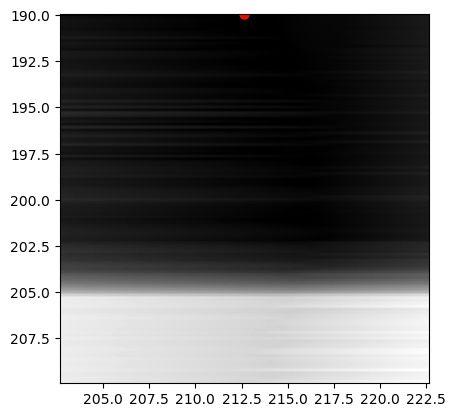

In [6]:
# current_time=None
num_episodes=150
episode_start=102
done_num=0
new_mol=True
for i_episode in range(episode_start,episode_start+num_episodes):
    print('Episode:', i_episode)
    episode_reward, episode_steps = 0, 0
    done = False
    if new_mol:
        state, info, check_similarity, candidate_mols = env.reset(all_file_label=str(i_episode),current_time=current_time, find_mol=True, new_scan_region=True, check_similarity=check_similarity, candidate_mols=candidate_mols)
    else:
        state, info, check_similarity, candidate_mols = env.reset(all_file_label=str(i_episode),current_time=current_time, find_mol=False, new_scan_region=True, check_similarity=check_similarity, candidate_mols=candidate_mols)
    current_time=env.get_state_current_time
    episode_memory.update_memory_reset(env.img_info, i_episode, info)


    for step in range(max_steps):
        action = agent.select_action(state)
        next_state, reward, done, info, new_mol = env.step(action, all_file_label=str(i_episode)+'_'+str(step),current_time=current_time, check_similarity=check_similarity, candidate_mols=candidate_mols)
        print('episode: %s reward: %s done: %s state: %s next_state: %s' % (str(i_episode)+'_'+str(step), reward, done, state, next_state))
        episode_steps+=1
        episode_reward+=reward
        mask = float(not done)
        memory.push(state,action,reward,next_state,mask)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)

        if done:
            done_num+=1
            # episode_memory.update_memory_done(env.img_info, [env.mol_center_x_nm, env.mol_center_y_nm], [0.0, 0.0])
            episode_memory.update_memory_done(env.img_info)
            episode_memory.save_memory(folder_name)
            print('Episode reward:', episode_reward)
            break
        else:
            state = next_state
            #state, info, check_similarity, candidate_mols = env.reset(all_file_label=str(i_episode)+str(step),current_time='10_30_20_48', new_scan_region=True, check_similarity=check_similarity, candidate_mols=candidate_mols)
        if new_mol:
            break

    if done_num>1:   
        if (len(memory)>batch_size):
            episode_K = int(episode_steps)
            for k in range(episode_K):
                c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
                agent.update_parameters(memory, batch_size, c_k)
    
    episode_rewards.append(episode_reward)
    alphas.append(agent.alpha.item())
    with open('episode_reward_1107.txt', 'a') as fp:
        fp.write('%s, %.2f, %.2f\n' % (i_episode, episode_reward, episode_steps))
    plt.scatter(i_episode, episode_reward, c='b')
    

    episode_lengths.append(episode_steps)
    avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
    avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
    avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
    

        
    if (i_episode)%5 == 0:
        torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
        torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
        torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))
        # torch.save(env.atom_move_detector.conv.state_dict(), '{}/_atom_move_detector_conv_{}.pth'.format(folder_name,i_episode))

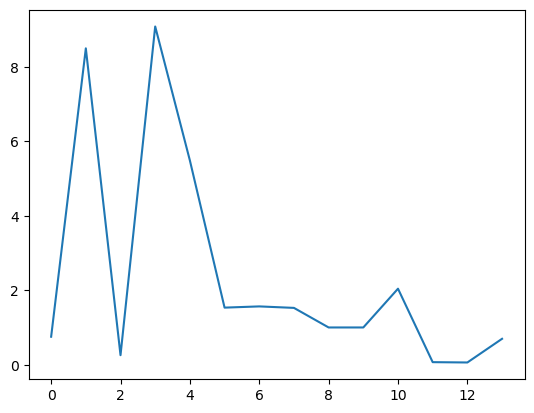

In [ ]:
plt.plot([i for i in range(len(episode_rewards))], episode_rewards)

In [ ]:
episode_rewards

[0.75120267868042,
 8.49965524673462,
 0.2552019119262695,
 9.087252235412596,
 5.487152481079101,
 1.533015823364258,
 1.565811634063721,
 1.5259997367858886,
 1.0,
 1.0,
 2.0415223121643065,
 0.0679102897644043,
 0.059212112426757814,
 0.6953644752502441]

In [ ]:
for i in range(100):

    state, info, check_similarity, candidate_mols = env.reset(all_file_label=str(i),current_time='10_30_20_48', new_scan_region=True, check_similarity=check_similarity, candidate_mols=candidate_mols)
    
    
    action = agent.select_action(state)
    next_state, reward, done, info = env.step(action, all_file_label=str(i),current_time='10_30_20_48', check_similarity=check_similarity, candidate_mols=candidate_mols)
    print('episode: %s reward: %s done: %s state: %s next_state: %s' % (i, reward, done, state, next_state))



The scan will take 43.9 seconds
Different prediction shows no dissociation
Epoch 0 dissociation topography: 0.6866905689239502
Epoch 0 scan a image after dissociating now....
The scan will take 43.9 seconds
Different prediction shows no dissociation
episode: 0 reward: 0.0 done: False state: [0.4466666666666667, 0.6566666666666666, 0.2437777777777778] next_state: [0.45, 0.7133333333333334, 0.23772222222222222]
The scan will take 43.9 seconds
Different prediction shows no dissociation
Epoch 1 dissociation topography: 0.4952723979949951
Epoch 1 scan a image after dissociating now....
The scan will take 43.9 seconds
adjust mol pos
The scan will take 43.9 seconds


In [ ]:
show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
        env.template_nm, env.template_wh)
episode_memory.update_memory_reset(env.img_info, i_episode, info)

In [ ]:
for i_episode in range(episode_start,episode_start+num_episodes):
    print('Episode:', i_episode)
    episode_reward, episode_steps = 0, 0
    done = False
    state, info = env.reset(update_conv_net=False)
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
            env.template_nm, env.template_wh)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    
    for step in range(max_steps):
        action = agent.select_action(state)
        old_atom_nm = env.atom_absolute_nm
        next_state, reward, done, info = env.step(action)
        episode_steps+=1
        episode_reward+=reward
        mask = float(not done)
        memory.push(state,action,reward,next_state,mask)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                    env.atom_absolute_nm, env.atom_start_absolute_nm, 
                    env.destination_absolute_nm, action[4]*env.max_mvoltage, 
                    action[5]*env.max_pcurrent*action[4]*env.max_mvoltage, 
                    env.template_nm, env.template_wh)
        print('step:', step,'reward', reward, 'precision:', env.dist_destination)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
            episode_memory.save_memory(folder_name)
            print('Episode reward:', episode_reward)
            break
        else:                
            state=next_state
        
    if (len(memory)>batch_size):
        episode_K = int(episode_steps)
        for k in range(episode_K):
            c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
            agent.update_parameters(memory, batch_size, c_k)
    
    episode_rewards.append(episode_reward)
    alphas.append(agent.alpha.item())
    precisions.append(env.dist_destination)
    episode_lengths.append(episode_steps)
    avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
    avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
    avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
    avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
    
    if (i_episode+1)%2==0:
        plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
        
    if (i_episode)%20 == 0:
        torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
        torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
        torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))
        torch.save(env.atom_move_detector.conv.state_dict(), '{}/_atom_move_detector_conv_{}.pth'.format(folder_name,i_episode))

In [ ]:
env.scan_ref_x_center = 187
env.scan_ref_y_center = -163
pixel_small=128
scan_len_nm_small=3.5
diss_maxtime=100
diss_radius_nm=1.0
diss_mvoltage_ref=2500
diss_pcurrent_ref=600
diss_z_nm=20
total_output_folder = 'all_output'
task_folder_prefix = 'vertmani'
save_scan_img_large_prefix = 'scan_img_large'
save_scan_img_before_prefix = 'scan_img_before'
save_scan_img_after_prefix = 'scan_img_after'
save_scan_data_large_prefix = 'scan_data_large'
save_scan_data_before_prefix = 'scan_data_before'
save_scan_data_after_prefix = 'scan_data_after'
save_vert_data_prefix = 'vert_data'
save_vert_tip_pos_prefix = 'vert_tip_pos'
current_time = datetime.datetime.now()
task_folder='%s/%s_%s_%s_%s_%s' % (total_output_folder, task_folder_prefix, current_time.month, current_time.day, current_time.hour, current_time.minute)
save_img_large='%s/%s_%s_%s_%s_%s' % (task_folder, save_scan_img_large_prefix, current_time.month, current_time.day, current_time.hour, current_time.minute)
save_img_before='%s/%s_%s_%s_%s_%s' % (task_folder, save_scan_img_before_prefix, current_time.month, current_time.day, current_time.hour, current_time.minute)
save_img_after='%s/%s_%s_%s_%s_%s' % (task_folder, save_scan_img_after_prefix, current_time.month, current_time.day, current_time.hour, current_time.minute)
save_data_large='%s/%s_%s_%s_%s_%s' % (task_folder, save_scan_data_large_prefix, current_time.month, current_time.day, current_time.hour, current_time.minute)
save_data_before='%s/%s_%s_%s_%s_%s' % (task_folder, save_scan_data_before_prefix, current_time.month, current_time.day, current_time.hour, current_time.minute)
save_data_after='%s/%s_%s_%s_%s_%s' % (task_folder, save_scan_data_after_prefix, current_time.month, current_time.day, current_time.hour, current_time.minute)
save_vert_data='%s/%s_%s_%s_%s_%s' % (task_folder, save_vert_data_prefix, current_time.month, current_time.day, current_time.hour, current_time.minute)
save_vert_tip_pos='%s/%s_%s_%s_%s_%s' % (task_folder, save_vert_tip_pos_prefix, current_time.month, current_time.day, current_time.hour, current_time.minute)

# check if these folders exist

if not os.path.exists(task_folder):
    os.mkdir(task_folder)
if not os.path.exists(save_img_large):
    os.mkdir(save_img_large)
if not os.path.exists(save_img_before):
    os.mkdir(save_img_before)
if not os.path.exists(save_img_after):
    os.mkdir(save_img_after)
if not os.path.exists(save_data_large):
    os.mkdir(save_data_large)
if not os.path.exists(save_data_before):
    os.mkdir(save_data_before)
if not os.path.exists(save_data_after):
    os.mkdir(save_data_after)
if not os.path.exists(save_vert_data):
    os.mkdir(save_vert_data)
if not os.path.exists(save_vert_tip_pos):
    os.mkdir(save_vert_tip_pos)

with open(task_folder+'/task_info.txt', 'w') as f:
    f.write('diss_maxtime: %s\n' % diss_maxtime)
    f.write('diss_radius_nm: %s\n' % diss_radius_nm)
    f.write('diss_mvoltage_ref: %s\n' % diss_mvoltage_ref)
    f.write('diss_pcurrent_ref: %s\n' % diss_pcurrent_ref)
    f.write('diss_z_nm: %s\n' % diss_z_nm)
    f.write('total_output_folder: %s\n' % total_output_folder)


mol_num=0
diss_i=0
mol_center_x_nm,mol_center_y_nm, check_similarity, candidate_mols=env.get_state(x_nm=env.createc_controller.get_offset_nm()[0], y_nm=env.createc_controller.get_offset_nm()[1], scan_len_nm_large=20, new_scan_region=True,img_name='%s_%s' % ('start', mol_num), data_name='%s_%s' % ('start', mol_num))
get_state_current_time=env.get_state_current_time
scan_mol_x_nm, scan_mol_y_nm = env.createc_controller.get_offset_nm()


find_mol=True

result=[]
for diss_i in tqdm(range(diss_maxtime)):
    while not find_mol:
            mol_center_x_nm,mol_center_y_nm, check_similarity, candidate_mols=env.get_state(x_nm=env.createc_controller.get_offset_nm()[0], y_nm=env.createc_controller.get_offset_nm()[1], scan_len_nm_large=20, new_scan_region=True, check_similarity=check_similarity, candidate_mols=candidate_mols,  current_time=get_state_current_time, img_name='%s_%s' % (diss_i, mol_num), data_name='%s_%s' % (diss_i, mol_num))
            scan_mol_x_nm, scan_mol_y_nm = env.createc_controller.get_offset_nm()
            find_mol=True
            # env.save_scan_image(x_nm=scan_mol_x_nm, y_nm=scan_mol_y_nm, pixel=pixel_small, scan_speed=200, scan_len_nm=scan_len_nm_small, save_img_folder=save_img_before, save_data_folder=save_data_before, img_name='%s_%s' % (diss_i, mol_num), data_name='%s_%s' % (diss_i, mol_num))
            # img_small=cv2.imread('%s/img_forward_%s_%s.png' % (save_img_before, diss_i, mol_num), cv2.IMREAD_GRAYSCALE)
            # img_prop_small=mol_property(img_small, offset_x_nm=scan_mol_x_nm, offset_y_nm=scan_mol_y_nm, len_nm=scan_len_nm_small)
            # img_prop_small.center_points_from_contour()
            # img_prop_small.contour_property()
            # mol_center_x_nm=img_prop_small.ellipse_x
            # mol_center_y_nm=img_prop_small.ellipse_y
            # try:
            #     env.adjust_mol_pos([mol_center_x_nm,mol_center_y_nm], scan_len_nm_small=3.5, pixel_small=128, scan_speed=200, save_img_folder=save_img_before, save_data_folder=save_data_before, img_name='%s_%s_adjust' % (diss_i, mol_num), data_name='%s_%s_adjust' % (diss_i, mol_num))
            #     scan_mol_x_nm, scan_mol_y_nm = env.createc_controller.get_offset_nm()
            #     find_mol=True
            # except:
            #     find_mol=False
    env.save_scan_image(x_nm=scan_mol_x_nm, y_nm=scan_mol_y_nm, pixel=pixel_small, scan_speed=200, scan_len_nm=scan_len_nm_small, save_img_folder=save_img_before, save_data_folder=save_data_before, img_name='%s_%s' % (diss_i, mol_num), data_name='%s_%s' % (diss_i, mol_num))
    img_small=cv2.imread('%s/img_forward_%s_%s.png' % (save_img_before, diss_i, mol_num), cv2.IMREAD_GRAYSCALE)
    img_prop_small=mol_property(img_small, offset_x_nm=scan_mol_x_nm, offset_y_nm=scan_mol_y_nm, len_nm=scan_len_nm_small)
    img_prop_small.center_points_from_contour()
    img_prop_small.contour_property()
    mol_center_x_nm=img_prop_small.ellipse_x
    mol_center_y_nm=img_prop_small.ellipse_y


    print('Epoch %s dissociation now' % diss_i)

    diss_x_nm=mol_center_x_nm+diss_radius_nm*(np.random.rand()*2-1)
    diss_y_nm=mol_center_y_nm+diss_radius_nm*(np.random.rand()*2-1)
    if diss_i<4:
        diss_mvoltage=diss_mvoltage_ref+400*(np.random.rand()*2-1)
        diss_pcurrent=diss_pcurrent_ref+200*(np.random.rand()*2-1)
    else:
        diss_mvoltage=diss_mvoltage_ref+1000*(np.random.rand()*2-1)
        diss_pcurrent=diss_pcurrent_ref+600*(np.random.rand()*2-1)


    vert_data=env.createc_controller.diss_manipulation(diss_x_nm, diss_y_nm, diss_z_nm, diss_mvoltage, diss_pcurrent, np.array([scan_mol_x_nm, scan_mol_y_nm]), scan_len_nm_small)
    done_diss=env.old_detect_diss(np.array(vert_data.topography))
    print('Epoch %s dissociation topography: %s' % (diss_i, env.diff_topography))
    vert_tip_pos=[diss_i, mol_center_x_nm, mol_center_y_nm, diss_x_nm, diss_y_nm, diss_z_nm, diss_mvoltage, diss_pcurrent, done_diss]
    with open(save_vert_data+'/vert_data_%s.pkl' % diss_i, "wb") as fp:  
        pickle.dump(vert_data, fp)
    with open(save_vert_tip_pos+'/vert_tip_pos_%s.pkl' % diss_i, "wb") as fp:
        pickle.dump(vert_tip_pos, fp)
    
    
    # tip forming
    print('start tip forming now')
    # env.tip_form_region()
    if done_diss or diss_i%10==5:
        env.tip_form_region()

        # scan image after manipulation
    print('Epoch %s scan a image after dissociating now....' % (diss_i))
    env.save_scan_image(x_nm=scan_mol_x_nm, y_nm=scan_mol_y_nm, pixel=pixel_small, scan_speed=200, scan_len_nm=scan_len_nm_small, save_img_folder=save_img_after, save_data_folder=save_data_after, img_name='%s_%s' % (diss_i, mol_num), data_name='%s_%s' % (diss_i, mol_num))
    img_small=cv2.imread('%s/img_forward_%s_%s.png' % (save_img_after, diss_i, mol_num), cv2.IMREAD_GRAYSCALE)
    img_prop_small=mol_property(img_small, offset_x_nm=scan_mol_x_nm, offset_y_nm=scan_mol_y_nm, len_nm=scan_len_nm_small)
    img_prop_small.center_points_from_contour()
    find_mol=False

    if len(img_prop_small.contours)>0 and len(img_prop_small.contours_max)>10 and  len(img_prop_small.detect_mols_from_contours)>0 and (not done_diss):
        img_prop_small.contour_property()
        if img_prop_small.area<3.0 and img_prop_small.area>0.5:
            mol_center_x_nm=img_prop_small.ellipse_x
            mol_center_y_nm=img_prop_small.ellipse_y
            if  mol_center_x_nm>scan_mol_x_nm-scan_len_nm_small/8 and mol_center_x_nm<scan_mol_x_nm+scan_len_nm_small/8 and mol_center_y_nm>scan_mol_y_nm+scan_len_nm_small*3/8 and mol_center_y_nm<scan_mol_y_nm+scan_len_nm_small*5/8:
                    scan_mol_x_nm, scan_mol_y_nm = env.createc_controller.get_offset_nm()
                    find_mol=True
           
            else:
                print('adjust mol pos')
                scan_mol_x_nm=mol_center_x_nm
                scan_mol_y_nm=mol_center_y_nm-scan_len_nm_small/2 
                env.save_scan_image(x_nm=scan_mol_x_nm, y_nm=scan_mol_y_nm, pixel=pixel_small, scan_speed=200, scan_len_nm=scan_len_nm_small, save_img_folder=save_img_after, save_data_folder=save_data_after, img_name='%s_%s_adjust' % (diss_i, mol_num), data_name='%s_%s_adjust' % (diss_i, mol_num))
    #        env.adjust_mol_pos([mol_center_x_nm,mol_center_y_nm], scan_len_nm_small=3.5, pixel_small=128, scan_speed=200, save_img_folder=save_img_after, save_data_folder=save_data_after, img_name='%s_%s_adjust' % (diss_i, mol_num), data_name='%s_%s_adjust' % (diss_i, mol_num))
                img_small=cv2.imread('%s/img_forward_%s_%s_adjust.png' % (save_img_after, diss_i, mol_num), cv2.IMREAD_GRAYSCALE)
                scan_mol_x_nm, scan_mol_y_nm = env.createc_controller.get_offset_nm()
                img_prop_small=mol_property(img_small, offset_x_nm=scan_mol_x_nm, offset_y_nm=scan_mol_y_nm, len_nm=scan_len_nm_small)
                img_prop_small.center_points_from_contour()
                img_prop_small.contour_property()
                if img_prop_small.area<3.0 and img_prop_small.area>1.5:
                    mol_center_x_nm=img_prop_small.ellipse_x
                    mol_center_y_nm=img_prop_small.ellipse_y
                    # env.adjust_mol_pos([mol_center_x_nm,mol_center_y_nm], scan_len_nm_small=3.5, pixel_small=128, scan_speed=200, save_img_folder=save_img_after, save_data_folder=save_data_after, img_name='%s_%s_adjust' % (diss_i, mol_num), data_name='%s_%s_adjust' % (diss_i, mol_num))
                    scan_mol_x_nm, scan_mol_y_nm = env.createc_controller.get_offset_nm()
                    find_mol=True

    while not find_mol:
            mol_num=mol_num+1
            find_mol=False
            mol_center_x_nm, mol_center_y_nm, check_similarity, candidate_mols=env.get_state(x_nm=env.createc_controller.get_offset_nm()[0], y_nm=env.createc_controller.get_offset_nm()[1], scan_len_nm_large=20, new_scan_region=True, check_similarity=check_similarity, candidate_mols=candidate_mols,  current_time=get_state_current_time, img_name='%s_%s' % (diss_i, mol_num), data_name='%s_%s' % (diss_i, mol_num))
            scan_mol_x_nm, scan_mol_y_nm = env.createc_controller.get_offset_nm()
            find_mol=True

            # try:
            #     env.adjust_mol_pos([mol_center_x_nm,mol_center_y_nm], scan_len_nm_small=3.5, pixel_small=128, scan_speed=200, save_img_folder=save_img_before, save_data_folder=save_data_before, img_name='%s_%s_adjust' % (diss_i, mol_num), data_name='%s_%s_adjust' % (diss_i, mol_num))
            #     scan_mol_x_nm, scan_mol_y_nm = env.createc_controller.get_offset_nm()
            #     find_mol=True
            # except:
            #     find_mol=False
            



    print('mol pos:', mol_center_x_nm, mol_center_y_nm)
    # result.append([img_prop_small.ellipse_x, img_prop_small.ellipse_y, img_prop_small.ellipse_width, img_prop_small.ellipse_height, img_prop_small.ellipse_angle])
    


start tip forming now
start scanning region: seek_time 1
The scan will take 50.5 seconds
candidate_mols [[211.07, -158.07], [211.17, -162.18], [199.59, -168.69]]
mol num: 0
The scan will take 50.5 seconds


  0%|          | 0/100 [00:00<?, ?it/s]

The scan will take 43.9 seconds
Epoch 0 dissociation now
Different prediction shows no dissociation
Epoch 0 dissociation topography: 0.02417778968811035
start tip forming now
Epoch 0 scan a image after dissociating now....
The scan will take 43.9 seconds
adjust mol pos
The scan will take 43.9 seconds


  1%|          | 1/100 [02:52<4:43:59, 172.12s/it]

mol pos: 210.55 -158.36
The scan will take 43.9 seconds
Epoch 1 dissociation now
Different prediction shows no dissociation
Epoch 1 dissociation topography: 0.2746701240539551
start tip forming now
Epoch 1 scan a image after dissociating now....
The scan will take 43.9 seconds


  2%|▏         | 2/100 [04:57<3:56:02, 144.52s/it]

mol pos: 210.5 -158.42
The scan will take 43.9 seconds
Epoch 2 dissociation now
Different prediction shows no dissociation
Epoch 2 dissociation topography: 0.28559398651123047
start tip forming now
Epoch 2 scan a image after dissociating now....
The scan will take 43.9 seconds


  3%|▎         | 3/100 [07:02<3:39:19, 135.67s/it]

mol pos: 210.45 -158.45
The scan will take 43.9 seconds
Epoch 3 dissociation now
Different prediction shows no dissociation
Epoch 3 dissociation topography: 0.10100936889648438
start tip forming now
Epoch 3 scan a image after dissociating now....
The scan will take 43.9 seconds


  4%|▍         | 4/100 [09:07<3:30:23, 131.49s/it]

mol pos: 210.4 -158.48
The scan will take 43.9 seconds
Epoch 4 dissociation now
Different prediction shows no dissociation
Epoch 4 dissociation topography: 0.3642151355743408
start tip forming now
Epoch 4 scan a image after dissociating now....
The scan will take 43.9 seconds


  5%|▌         | 5/100 [11:12<3:24:35, 129.22s/it]

mol pos: 210.36 -158.51
The scan will take 43.9 seconds
Epoch 5 dissociation now
Different prediction shows no dissociation
Epoch 5 dissociation topography: 0.22027921676635742
start tip forming now
start tip forming now
Epoch 5 scan a image after dissociating now....
The scan will take 43.9 seconds
start tip forming now
mol num: 0
The scan will take 43.9 seconds
The scan will take 43.9 seconds


  6%|▌         | 6/100 [15:35<4:33:35, 174.63s/it]

mol pos: 210.36 -162.52
The scan will take 43.9 seconds
Epoch 6 dissociation now
Epoch 6 dissociation topography: 12.016618013381958
start tip forming now
start tip forming now
Epoch 6 scan a image after dissociating now....
The scan will take 43.9 seconds
start tip forming now
mol num: 0
The scan will take 43.9 seconds
The scan will take 43.9 seconds


  7%|▋         | 7/100 [19:56<5:14:13, 202.73s/it]

mol pos: 199.23 -168.74
The scan will take 43.9 seconds
Epoch 7 dissociation now
Different prediction shows no dissociation
Epoch 7 dissociation topography: 0.757540225982666
start tip forming now
Epoch 7 scan a image after dissociating now....
The scan will take 43.9 seconds


  8%|▊         | 8/100 [21:59<4:32:20, 177.61s/it]

mol pos: 199.33 -168.72
The scan will take 43.9 seconds
Epoch 8 dissociation now
Different prediction shows no dissociation
Epoch 8 dissociation topography: 0.1717545986175537
start tip forming now
Epoch 8 scan a image after dissociating now....
The scan will take 43.9 seconds


  9%|▉         | 9/100 [24:03<4:03:47, 160.74s/it]

mol pos: 199.31 -168.76
The scan will take 43.9 seconds
Epoch 9 dissociation now
Different prediction shows no dissociation
Epoch 9 dissociation topography: 0.20505857467651367
start tip forming now
Epoch 9 scan a image after dissociating now....
The scan will take 43.9 seconds


 10%|█         | 10/100 [26:09<3:44:46, 149.84s/it]

mol pos: 199.31 -168.79
The scan will take 43.9 seconds


In [ ]:
c

AttributeError: 'DissociateEnv' object has no attribute 'get_nextgoodcloest'

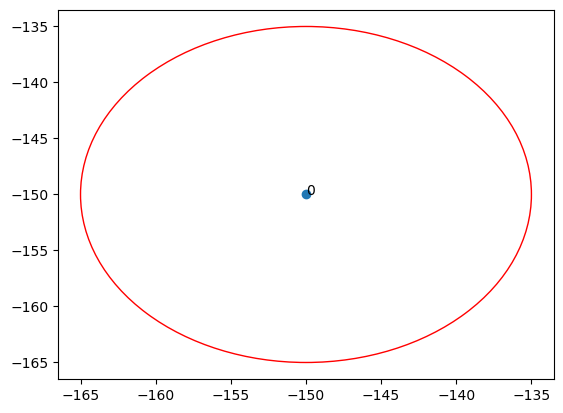

In [ ]:
# env.scan_ref_x=-100
# env.scan_ref_y=-100
x, y=-305.88761711120605, -240.23584938049316
x, y= -150, -150
env.scan_ref_x=x
env.scan_ref_y=y
check_similarity=None
# check_similarity.append([x,y])
forbid_radius=15
simi_forbid_radius=15
plt.scatter(x,y)
plt.text(x,y,0)
plt.gca().add_patch(patches.Circle((x,y), radius=forbid_radius, fill=False, color='r'))
for i  in range(20):
    # if i%4==0:
    #     x,y =env.get_nextgoodcloest(x, y, approach_limit=[-310, 0, -260, 0], forbid_radius=forbid_radius*2, simi_forbid_radius=simi_forbid_radius*2, detect_similarity=True, check_similarity=check_similarity)
    #     plt.gca().add_patch(patches.Circle((x,y), radius=forbid_radius*2, fill=False, color='r'))
    # else:
    x,y =env.get_nextgoodcloest(x, y, approach_limit=[-310, 0, -260, 0], forbid_radius=forbid_radius, simi_forbid_radius=simi_forbid_radius, detect_similarity=True, check_similarity=check_similarity)
    check_similarity.append([x,y])
    plt.text(x,y,i+1)
    plt.gca().add_patch(patches.Rectangle((x-5,y-10), 10, 10, fill=False, color='r'))
    # plt.gca().add_patch(patches.Circle((x,y), radius=forbid_radius, fill=False, color='r'))



plt.xlim(-320, 320)
plt.ylim(-320, 260)

In [ ]:
env.num_cell

15

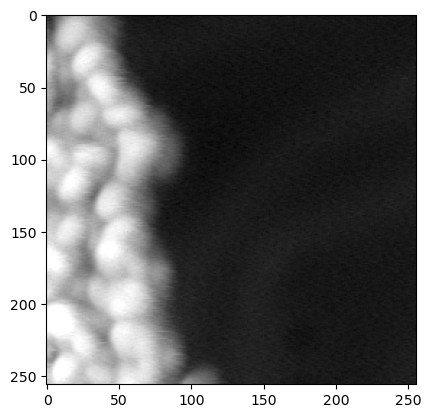

In [ ]:
img_10nm=cv2.imread('img_10nm_new_10.jpeg') 
plt.imshow(img_10nm)    

  0%|          | 0/11078 [00:00<?, ?it/s]

100%|██████████| 11078/11078 [00:00<00:00, 47908.76it/s]


27
0
5
19
2
6
16
1
1
16
5
18
5
10
1
8
9
2
7
9
4
2
2
0
0
1
0
0
0
0


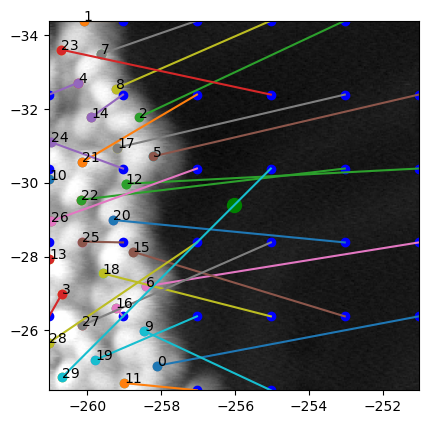

In [ ]:
selected_points, target_points = assign_point_to_point=assign_mol_design(img_10nm, x_nm=-256.034, y_nm=-34.382,len_nm=10, pixel=256, grid_num=6)

In [ ]:
selected_points=[selected_points[i] for i in [0, 1, 2, 5, 6, 7, 8, 9]]
target_points=[target_points[i] for i in [0, 1, 2, 5, 6, 7, 8, 9]]

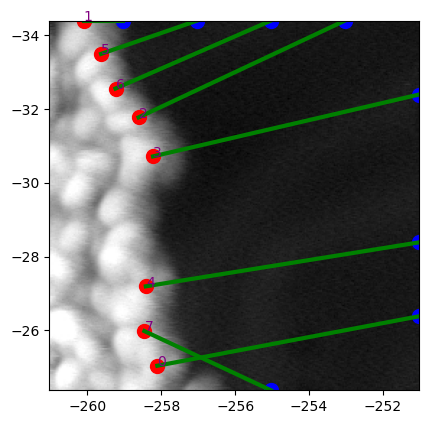

In [ ]:
plt.imshow(img_10nm, extent=[-261.034, -251.034, -24.382, -34.382])
for i in range(len(selected_points)):
    plt.text(selected_points[i][0], selected_points[i][1], str(i), color='purple', fontsize=10)
    plt.scatter(selected_points[i][0], selected_points[i][1], c='r', s=100)
    plt.scatter(target_points[i][0], target_points[i][1], c='b', s=100)
    plt.plot([selected_points[i][0], target_points[i][0]], [selected_points[i][1], target_points[i][1]], c='g', linewidth=3)




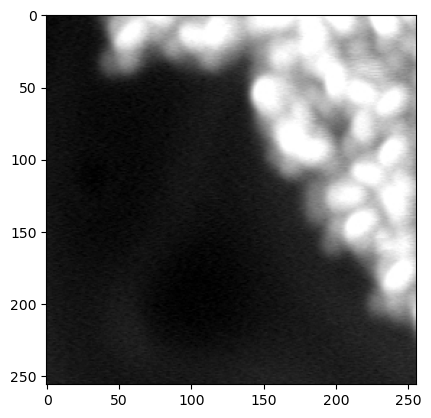

In [ ]:
img_10nm=cv2.imread('img_10nm_new_11.jpeg') 
plt.imshow(img_10nm)    

  0%|          | 0/13980 [00:00<?, ?it/s]

100%|██████████| 13980/13980 [00:00<00:00, 49564.15it/s]


22
8
0
0
13
9
14
4
26
25
22
18
0
1
19
3
18
6
16
0
14
12
5
11
9
7
5
7
2
2
3
3
0
1
0


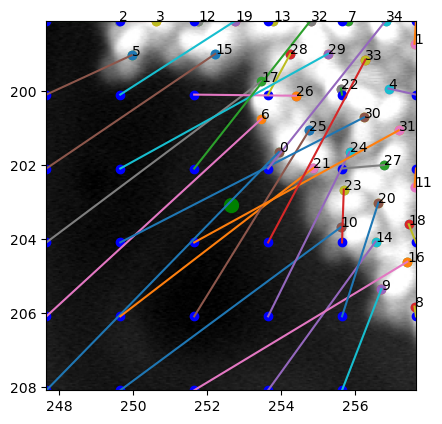

In [ ]:
selected_points, target_points = assign_point_to_point=assign_mol_design(img_10nm, x_nm=252.654, y_nm=198.085, len_nm=10, pixel=256, grid_num=6)

In [ ]:
selected_points=[selected_points[i] for i in [0, 2, 5, 6, 9, 10, 14, 15, 21, 23]]
target_points=[target_points[i] for i in [0, 2, 5, 6, 9, 10, 14, 15, 21, 23]]

249.607125 193.085 249.17818946157882 198.42600794909094 247.59089716503794 247.59089716503794
249.607125 193.085 250.00035907315086 197.80221343577796 247.6388405896309 247.6388405896309
249.607125 193.085 249.84434563890218 197.84927031697907 247.9503969138613 247.9503969138613
249.9586875 194.0225 249.7410998644034 199.16242838587502 247.98275294731062 247.98275294731062
249.9586875 194.0225 249.60429657852518 199.19693587403256 247.60375097168756 247.60375097168756
249.9586875 194.0225 249.82271283902995 199.21691584061207 247.37799896286734 247.37799896286734
253.4743125 195.74125 253.77290385468515 200.9790301619604 247.846963837981 247.846963837981
253.4743125 195.74125 253.8193980368149 200.32211495519886 247.17791864842457 247.17791864842457
253.4743125 195.74125 253.08792637784146 201.0732855617482 248.15060437884372 248.15060437884372
256.7165 200.350625 257.17321586681425 205.8090670707419 255.5687793409347 255.5687793409347
256.7165 200.350625 256.3449023103194 205.2589354

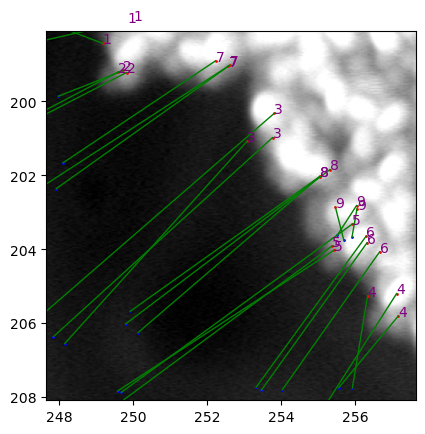

In [ ]:
lat_mani_separate_mols(img_10nm, selected_points, target_points)

The scan will take 83.9 seconds
249.607125 193.085 249.45359381628091 198.32783138991124 247.88564759045744 247.88564759045744
The scan will take 83.9 seconds
The scan will take 83.9 seconds
249.607125 193.085 249.7653370694239 198.37359746311188 248.1192377527649 248.1192377527649
The scan will take 83.9 seconds
The scan will take 83.9 seconds
249.607125 193.085 249.4721065843547 197.6305374978529 247.57352023487303 247.57352023487303
The scan will take 83.9 seconds
The scan will take 83.9 seconds
249.9586875 194.0225 250.27730176785454 199.05849085734062 247.30955255193376 247.30955255193376
The scan will take 83.9 seconds
The scan will take 83.9 seconds
249.9586875 194.0225 250.3724383099683 198.82420888634633 247.74608883678485 247.74608883678485
The scan will take 83.9 seconds
The scan will take 83.9 seconds
249.9586875 194.0225 249.64365014285357 199.0803601002333 247.2574405252927 247.2574405252927
The scan will take 83.9 seconds
The scan will take 83.9 seconds
253.4743125 195.7

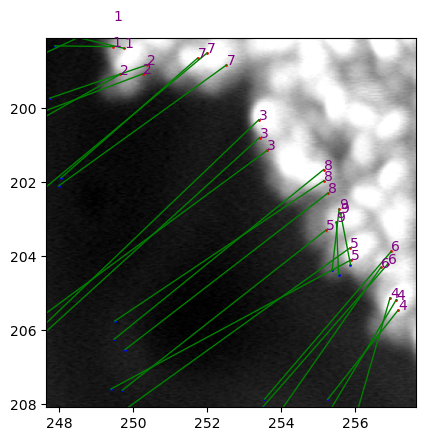

In [ ]:
lat_mani_separate_mols(img_10nm, selected_points, target_points, implement=False)

NameError: name 'tip_lat_all' is not defined

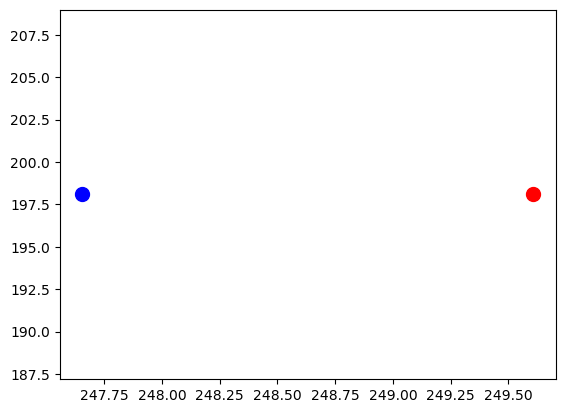

In [ ]:
x_nm=-256.034
y_nm=-34.382
len_nm=10
num_lat=0
for i in range(1, 7):
    # x=x_nm-len_nm/2+len_nm/pixel*selected_points[i][0]
    # y=y_nm+len_nm/pixel*selected_points[i][1]
    # x_end=x_nm-len_nm/2+len_nm/pixel*target_points[i][2]
    # y_end=y_nm+len_nm/pixel*target_points[i][3]
    # plt.scatter([x], [y], s=1, c='r')

    x=selected_points[i][0]
    y=selected_points[i][1]
    x_end=target_points[i][0]
    y_end=target_points[i][1]

    plt.scatter([x], [y], s=100, c='r')
    plt.scatter([x_end], [y_end], s=100, c='b')
    # plt.plot([x, x_end], [y, y_end], c='g', linewidth=1)

    # check_points.remove([data['x'][i], data['y'][i]])
    for epoch in range(3):
        if (tip_lat_all[num_lat][0]==i) and (tip_lat_all[num_lat][1]==epoch):
            tip_lat_start_end=tip_lat_all[num_lat]
            plt.scatter([tip_lat_start_end[2]], [tip_lat_start_end[3]], s=1, c='r')
            plt.scatter([tip_lat_start_end[4]], [tip_lat_start_end[5]], s=1, c='b')
            plt.plot([tip_lat_start_end[2], tip_lat_start_end[4]], [tip_lat_start_end[3], tip_lat_start_end[5]], c='g', linewidth=1)
            plt.text(tip_lat_start_end[2], tip_lat_start_end[3], i, color='purple', fontsize=10)
            num_lat+=1
        else:
            pass

plt.xlim(x_nm-len_nm/2-2, x_nm+len_nm/2+2)
plt.ylim(y_nm+len+2, y_nm-2)

In [ ]:
def lat_mani_separate_mols(img, selected_points, target_points, x_nm=252.654, y_nm=198.085, len_nm=10, pixel=256, init_len=0.5, move_len=5, scan_nm_small=10, tip_form_x=225.781, tip_form_y=215.751, tip_len=100, plot_graph=True, implement=True):

    # check_points=[[data['x'][i], data['y'][i]] for i in range(len(data))]
    # check_points_full=[[data['x'][i], data['y'][i]] for i in range(len(data))]
    check_points=[[selected_points[i][0], selected_points[i][1]] for i in range(len(selected_points))]
    check_points_full=[[selected_points[i][0], selected_points[i][1]] for i in range(len(selected_points))]


    move_points=[]
    plt.imshow(img, extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm+len_nm, y_nm])

    data_move_all=[]

    tip_points=[]
    tip_points.append([tip_form_x, tip_form_y])
    tip_lat_all=[]
    current_time = datetime.datetime.now()
    save_before_img='img_before_move_%s_%s_%s_%s' % (current_time.month, current_time.day, current_time.hour, current_time.minute)
    save_after_img='img_after_move_%s_%s_%s_%s' % (current_time.month, current_time.day, current_time.hour, current_time.minute)
    save_lat_data='lat_data_%s_%s_%s_%s.pkl' % (current_time.month, current_time.day, current_time.hour, current_time.minute)
    save_tip_pos='tip_pos_%s_%s_%s_%s.pkl' % (current_time.month, current_time.day, current_time.hour, current_time.minute)

    if not os.path.exists(save_before_img):
        os.mkdir(save_before_img)
    if not os.path.exists(save_after_img):
        os.mkdir(save_after_img)
    save_mani_pkl='data_move_%s_%s_%s_%s.pkl' % (current_time.month, current_time.day, current_time.hour, current_time.minute)
    # for i in range(len(data)):
    for i in range(1, len(selected_points)):
    # for i in tqdm(range(1, 7)):
        # x=x_nm-len_nm/2+len_nm/pixel*selected_points[i][0]
        # y=y_nm+len_nm/pixel*selected_points[i][1]
        # x_end=x_nm-len_nm/2+len_nm/pixel*target_points[i][2]
        # y_end=y_nm+len_nm/pixel*target_points[i][3]
        # plt.scatter([x], [y], s=1, c='r')

        x=selected_points[i][0]
        y=selected_points[i][1]
        x_end=target_points[i][0]
        y_end=target_points[i][1]

        # check_points.remove([data['x'][i], data['y'][i]])
        for epoch in range(3):
            tip_start_x=x+init_len*(np.random.rand()*2-1)
            tip_start_y=y+init_len*(np.random.rand()*2-1)

            tip_end_x=x_end+init_len*(np.random.rand()*2-1)
            tip_end_y=y_end+init_len*(np.random.rand()*2-1)

            # tip_end_x=tip_start_x+move_len*(np.random.rand()*2-1)
            # tip_end_y=tip_start_y+move_len*(np.random.rand()*2-1)
            check_points_array=np.array(check_points)

            # for find_epoch in range(50):
            #     if np.sqrt((check_points_array[:, 0]-tip_end_x)**2+(check_points_array[:, 1]-tip_end_y)**2).min()<2:
            #         tip_end_x=tip_start_x+init_len*(np.random.rand()*2-1)
            #         tip_end_y=tip_start_y+init_len*(np.random.rand()*2-1)
            #     else:
            #         if find_epoch==49:
            #             break
            #         else:
            #             pass    

            # env.createc_controller.offset_nm = np.array([x, y-scan_nm_small/2])
            if not implement:
                env.createc_controller.offset_nm = np.array([x_nm, y_nm])
                env.createc_controller.im_size_nm= scan_nm_small
                scan_data=env.createc_controller.scan_image()
                plt.imsave('%s/image_forward_%s_%s.png' % (save_before_img, i, epoch), scan_data[0])
                plt.imsave('%s/image_backward_%s_%s.png' % (save_before_img, i, epoch), scan_data[1])
                plt.imsave('%s/image_for_back_%s_%s.png' % (save_before_img, i, epoch), (scan_data[0]+scan_data[1])/2)

            check_points.append([tip_end_x, tip_end_y])
            check_points_full.append([tip_end_x, tip_end_y])
            move_points.append([tip_end_x, tip_end_y])
            plt.scatter([tip_start_x], [tip_start_y], s=1, c='r')
            plt.scatter([tip_end_x], [tip_end_y], s=1, c='b')
            plt.plot([tip_start_x, tip_end_x], [tip_start_y, tip_end_y], c='g', linewidth=1)
            plt.text(tip_start_x, tip_start_y, i, color='purple', fontsize=10)
            print(x, y-scan_nm_small/2, tip_start_x, tip_start_y, tip_end_x, tip_end_x)
            tip_lat_all.append([i, epoch, tip_start_x, tip_start_y, tip_end_x, tip_end_y])

            # data_move=env.createc_controller.lat_manipulation(tip_start_x, tip_start_y, tip_end_x, tip_end_y, 32, 1000, np.array([x, y-scan_nm_small/2]), scan_nm_small)
            if not implement:
                data_move=env.createc_controller.lat_manipulation(tip_start_x, tip_start_y, tip_end_x, tip_end_y, 32, 1000, np.array([x_nm, y_nm]), scan_nm_small)
                data_move_all.append(data_move)
                # env.createc_controller.offset_nm = np.array([x, y-scan_nm_small/2])
                env.createc_controller.offset_nm = np.array([x_nm, y_nm])
                env.createc_controller.im_size_nm= scan_nm_small
                scan_data=env.createc_controller.scan_image()
                plt.imsave('%s/image_forward_%s_%s.png' % (save_after_img, i, epoch), scan_data[0])
                plt.imsave('%s/image_backward_%s_%s.png' % (save_after_img, i, epoch), scan_data[1])
                plt.imsave('%s/image_for_back_%s_%s.png' % (save_after_img, i, epoch), (scan_data[0]+scan_data[1])/2)
                #  tip form
                for j in range(2):
                    tip_x=tip_form_x-tip_len/2+tip_len*np.random.rand()
                    tip_y=tip_form_y+tip_len*np.random.rand()
                    check_tip_points_array=np.array(tip_points)
                    while np.sqrt((check_tip_points_array[:, 0]-tip_x)**2+(check_tip_points_array[:, 1]-tip_y)**2).min()<2:
                        tip_x=tip_form_x+tip_len*np.random.rand()
                        tip_y=tip_form_y+tip_len*np.random.rand()
                    up_limit=35
                    down_limit=10
                    tip_z_approach=down_limit+np.random.rand()*(up_limit-down_limit)
                    env.createc_controller.tip_form(tip_z_approach, tip_x, tip_y, np.array([tip_form_x, tip_form_y]), tip_len)  
                    tip_points.append([tip_x, tip_y])
                    env.createc_controller.set_Z_approach(15)

           

    if not implement:
        env.createc_controller.offset_nm = np.array([x_nm, y_nm])
        env.createc_controller.im_size_nm= scan_nm_small
        scan_data=env.createc_controller.scan_image()



        # check_points.append([data['x'][i], data['y'][i]])  # restore all points in data plus tip_end_points

        with open(save_mani_pkl, "wb") as fp:   #Pickling
            pickle.dump(data_move_all, fp)
        
        with open(save_lat_data, "wb") as fp:   #Pickling
            pickle.dump(tip_lat_all, fp)
        
        with open(save_tip_pos, "wb") as fp:   #Pickling
            pickle.dump(tip_points, fp)

    plt.xlim(x_nm-len_nm/2, x_nm+len_nm/2)
    plt.ylim(y_nm+len_nm, y_nm)
    

-260.0965 -39.382 -260.2105035105443 -34.741882022615755 -259.3749808973082 -259.3749808973082
-260.0965 -39.382 -260.0467736305859 -34.183824478532514 -258.73891997334226 -258.73891997334226
-260.0965 -39.382 -260.29880832529807 -34.597236273038966 -259.3379043616937 -259.3379043616937
-258.612125 -36.7648125 -258.86370905156116 -32.19397950812499 -252.56232475438657 -252.56232475438657
-258.612125 -36.7648125 -258.22566731229506 -31.72286137409711 -252.95438682496322 -252.95438682496322
-258.612125 -36.7648125 -258.98235739936587 -31.53447849098896 -252.5751780421139 -252.5751780421139
-258.2215 -35.710125 -258.71551066156917 -30.976114605517402 -251.18148612387628 -251.18148612387628
-258.2215 -35.710125 -257.77985060016846 -30.727005060574353 -251.24068774820844 -251.24068774820844
-258.2215 -35.710125 -257.8900166141675 -30.87147645024021 -251.18545751918452 -251.18545751918452
-258.4168125 -32.1945 -258.5478008470486 -27.544330968198032 -251.39979413644315 -251.39979413644315
-25

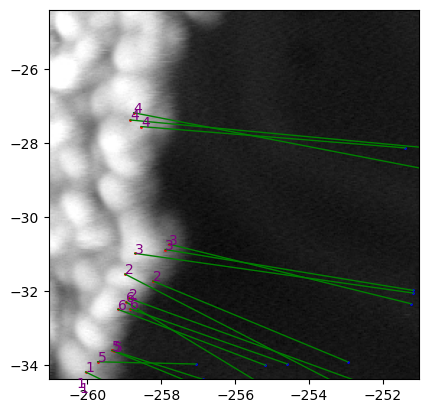

In [ ]:
lat_mani_separate_mols(selected_points, target_points)

The scan will take 83.9 seconds
-260.0965 -39.382 -260.17478147690974 -34.32516058250998 -255.8817376934059 -255.8817376934059
The scan will take 83.9 seconds
The scan will take 83.9 seconds
-260.0965 -39.382 -260.4245614530928 -34.851597009565175 -262.2706208940597 -262.2706208940597
The scan will take 83.9 seconds
The scan will take 83.9 seconds
-260.0965 -39.382 -260.51617441779257 -34.51927524588462 -263.81710097298554 -263.81710097298554
The scan will take 83.9 seconds
The scan will take 83.9 seconds
-258.612125 -36.7648125 -259.0899606778004 -31.38105646128021 -252.80586571581634 -252.80586571581634
The scan will take 83.9 seconds
The scan will take 83.9 seconds
-258.612125 -36.7648125 -258.4665157094923 -32.14564774494206 -262.4734109671991 -262.4734109671991
The scan will take 83.9 seconds
The scan will take 83.9 seconds
-258.612125 -36.7648125 -258.94203452902826 -31.412326286162294 -254.0883018245346 -254.0883018245346
The scan will take 83.9 seconds
The scan will take 83.9 s

(-34.382, -24.381999999999998)

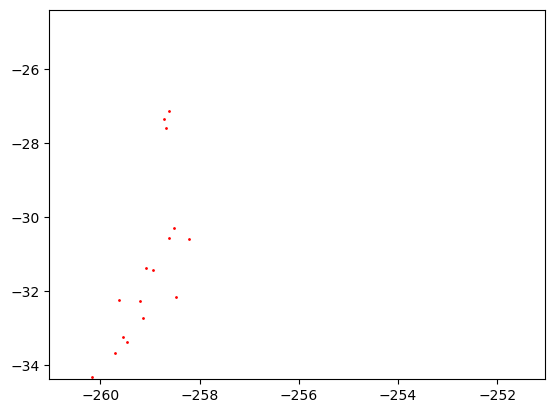

In [ ]:
ref_x=147
ref_y=141
x_nm=-256.034
y_nm=-34.382
len_nm=10  # nm
pixel=256
init_len=0.5 # nm
move_len=5 # nm
# check_points=[[data['x'][i], data['y'][i]] for i in range(len(data))]
# check_points_full=[[data['x'][i], data['y'][i]] for i in range(len(data))]
check_points=[[selected_points[i][0], selected_points[i][1]] for i in range(len(selected_points))]
check_points_full=[[selected_points[i][0], selected_points[i][1]] for i in range(len(selected_points))]
scan_nm_small=10

move_points=[]
# plt.imshow(img, extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm+len_nm, y_nm])

data_move_all=[]
tip_form_x=-326.117
tip_form_y=-113.864
tip_len=70
tip_points=[]
tip_points.append([tip_form_x, tip_form_y])
tip_lat_all=[]
current_time = datetime.datetime.now()
save_before_img='img_before_move_%s_%s_%s_%s' % (current_time.month, current_time.day, current_time.hour, current_time.minute)
save_after_img='img_after_move_%s_%s_%s_%s' % (current_time.month, current_time.day, current_time.hour, current_time.minute)
if not os.path.exists(save_before_img):
    os.mkdir(save_before_img)
if not os.path.exists(save_after_img):
    os.mkdir(save_after_img)
save_mani_pkl='data_move_%s_%s_%s_%s.pkl' % (current_time.month, current_time.day, current_time.hour, current_time.minute)
# for i in range(len(data)):
#for i in range(1, len(selected_points)):
for i in range(1, 7):
    # x=x_nm-len_nm/2+len_nm/pixel*selected_points[i][0]
    # y=y_nm+len_nm/pixel*selected_points[i][1]
    # x_end=x_nm-len_nm/2+len_nm/pixel*target_points[i][2]
    # y_end=y_nm+len_nm/pixel*target_points[i][3]
    # plt.scatter([x], [y], s=1, c='r')

    x=selected_points[i][0]
    y=selected_points[i][1]
    x_end=target_points[i][0]
    y_end=target_points[i][1]

    # check_points.remove([data['x'][i], data['y'][i]])
    for epoch in range(3):
        tip_start_x=x+init_len*(np.random.rand()*2-1)
        tip_start_y=y+init_len*(np.random.rand()*2-1)

        tip_end_x=x_end+init_len*(np.random.rand()*2-1)
        tip_end_y=y_end+init_len*(np.random.rand()*2-1)

        # tip_end_x=tip_start_x+move_len*(np.random.rand()*2-1)
        # tip_end_y=tip_start_y+move_len*(np.random.rand()*2-1)
        check_points_array=np.array(check_points)

        # for find_epoch in range(50):
        #     if np.sqrt((check_points_array[:, 0]-tip_end_x)**2+(check_points_array[:, 1]-tip_end_y)**2).min()<2:
        #         tip_end_x=tip_start_x+init_len*(np.random.rand()*2-1)
        #         tip_end_y=tip_start_y+init_len*(np.random.rand()*2-1)
        #     else:
        #         if find_epoch==49:
        #             break
        #         else:
        #             pass    

        # env.createc_controller.offset_nm = np.array([x, y-scan_nm_small/2])
        env.createc_controller.offset_nm = np.array([x_nm, y_nm])
        env.createc_controller.im_size_nm= scan_nm_small
        scan_data=env.createc_controller.scan_image()
        plt.imsave('%s/image_forward_%s_%s.png' % (save_before_img, i, epoch), scan_data[0])
        plt.imsave('%s/image_backward_%s_%s.png' % (save_before_img, i, epoch), scan_data[1])
        plt.imsave('%s/image_for_back_%s_%s.png' % (save_before_img, i, epoch), (scan_data[0]+scan_data[1])/2)

        check_points.append([tip_end_x, tip_end_y])
        check_points_full.append([tip_end_x, tip_end_y])
        move_points.append([tip_end_x, tip_end_y])
        plt.scatter([tip_start_x], [tip_start_y], s=1, c='r')
        print(x, y-scan_nm_small/2, tip_start_x, tip_start_y, tip_end_x, tip_end_x)
        # data_move=env.createc_controller.lat_manipulation(tip_start_x, tip_start_y, tip_end_x, tip_end_y, 32, 1000, np.array([x, y-scan_nm_small/2]), scan_nm_small)
        data_move=env.createc_controller.lat_manipulation(tip_start_x, tip_start_y, tip_end_x, tip_end_y, 32, 1000, np.array([x_nm, y_nm]), scan_nm_small)
        tip_lat_all.append([i, epoch, tip_start_x, tip_start_y, tip_end_x, tip_end_y])
        data_move_all.append(data_move)
        # env.createc_controller.offset_nm = np.array([x, y-scan_nm_small/2])
        env.createc_controller.offset_nm = np.array([x_nm, y_nm])
        env.createc_controller.im_size_nm= scan_nm_small
        scan_data=env.createc_controller.scan_image()
        plt.imsave('%s/image_forward_%s_%s.png' % (save_after_img, i, epoch), scan_data[0])
        plt.imsave('%s/image_backward_%s_%s.png' % (save_after_img, i, epoch), scan_data[1])
        plt.imsave('%s/image_for_back_%s_%s.png' % (save_after_img, i, epoch), (scan_data[0]+scan_data[1])/2)
    

       # if epoch==2:
        for j in range(2):
            tip_x=tip_form_x-tip_len/2+tip_len*np.random.rand()
            tip_y=tip_form_y+tip_len*np.random.rand()
            check_tip_points_array=np.array(tip_points)
            while np.sqrt((check_tip_points_array[:, 0]-tip_x)**2+(check_tip_points_array[:, 1]-tip_y)**2).min()<2:
                tip_x=tip_form_x+tip_len*np.random.rand()
                tip_y=tip_form_y+tip_len*np.random.rand()
            up_limit=35
            down_limit=10
            tip_z_approach=down_limit+np.random.rand()*(up_limit-down_limit)
            env.createc_controller.tip_form(tip_z_approach, tip_x, tip_y, np.array([tip_form_x, tip_form_y]), tip_len)  
            tip_points.append([tip_x, tip_y])
            env.createc_controller.set_Z_approach(15)

env.createc_controller.offset_nm = np.array([x_nm, y_nm])
env.createc_controller.im_size_nm= scan_nm_small
scan_data=env.createc_controller.scan_image()



    # check_points.append([data['x'][i], data['y'][i]])  # restore all points in data plus tip_end_points

with open(save_mani_pkl, "wb") as fp:   #Pickling
    pickle.dump(data_move_all, fp)
plt.xlim(x_nm-len_nm/2, x_nm+len_nm/2)
plt.ylim(y_nm, y_nm+len_nm)

In [ ]:
env.createc_controller.offset_nm = np.array([x_nm, y_nm])
env.createc_controller.im_size_nm= scan_nm_small
scan_data=env.createc_controller.scan_image()

The scan will take 83.9 seconds


(6.159, 16.159)

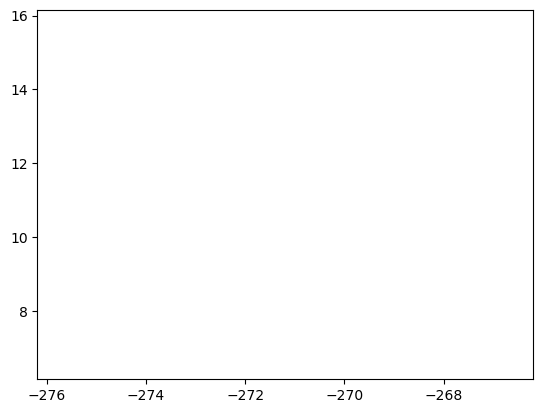

In [ ]:
with open(save_mani_pkl, "wb") as fp:   #Pickling
    pickle.dump(data_move_all, fp)
plt.xlim(x_nm-len_nm/2, x_nm+len_nm/2)
plt.ylim(y_nm, y_nm+len_nm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(Text(0.5, 1.0, 'Sobel Y'), ([], []), ([], []))

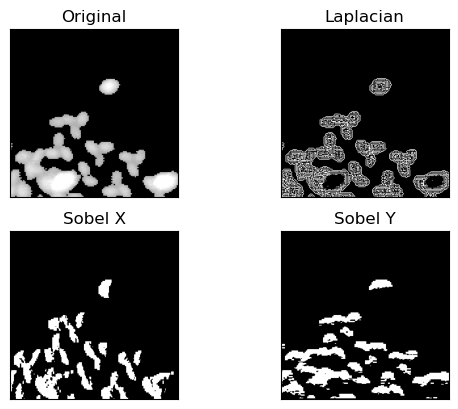

In [ ]:
img=cv2.imread('diss_10nm.jpeg') 
img[img<170]=0
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

In [ ]:
env.createc_controller.get_offset_nm()

(132.9959201812744, -116.99642372131348)

In [ ]:
0.5 angstrom   # if tip changes

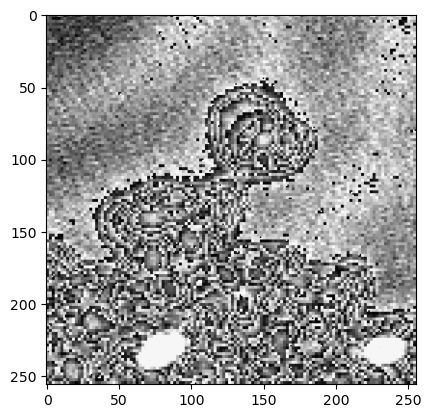

In [ ]:
# img_10nm[img_10nm<170]=0

plt.imshow(img_10nm*10)

In [ ]:
img_10nm[img_10nm<180]=0

In [ ]:
def show_image_treatment(img):
    sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
    # Output dtype = cv.CV_64F. Then take its absolute and convert to cv.CV_8U
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobel_8u = np.uint8(abs_sobel64f)
    plt.subplot(1,3,1),plt.imshow(img,cmap = 'gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(sobelx8u,cmap = 'gray')
    plt.title('Sobel CV_8U'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(sobel_8u,cmap = 'gray')
    plt.title('Sobel abs(CV_64F)'), plt.xticks([]), plt.yticks([])

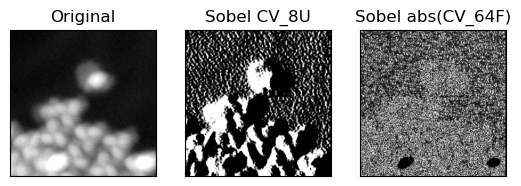

In [ ]:
show_image_treatment(img_10nm)

In [ ]:
from tqdm import tqdm

In [ ]:
detect_mols=np.where(img_10nm>180)
img_10nm[img_10nm<190]=0

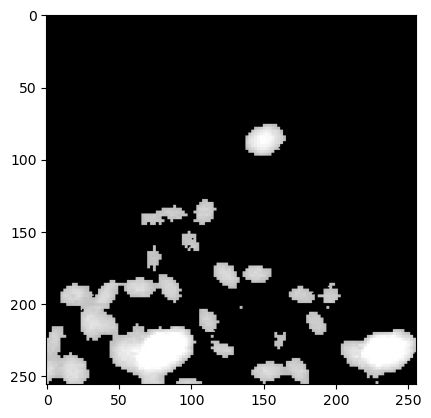

In [ ]:
plt.imshow(img_10nm)

In [ ]:
len(detect_mols[0])

30990

In [ ]:
detect_mols=np.where(img_10nm>180)
for i in tqdm(range(len(detect_mols[0]))):
    # plt.imshow(edges, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    plt.imshow(img_10nm, extent=[x_nm-10/2, x_nm+10/2, y_nm+10, y_nm])
    plt.scatter(x_nm-10/2+detect_mols[1][i]*10/128, y_nm+detect_mols[0][i]*10/128, s=1, c='r')

In [ ]:
detect_mols=np.where(img_10nm>180)
data_blob ={'x': detect_mols[1], 'y': detect_mols[0]}
data_blob=pd.DataFrame(data_blob)
data_blob=data_blob.drop_duplicates(ignore_index=True)

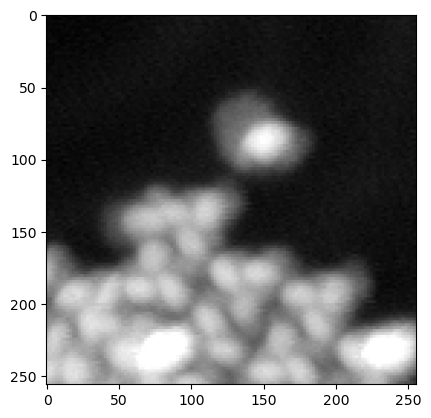

In [ ]:
plt.imshow(img_10nm)

  0%|          | 0/10330 [00:00<?, ?it/s]

100%|██████████| 10330/10330 [00:00<00:00, 47543.25it/s]


(-313.461, -323.461)

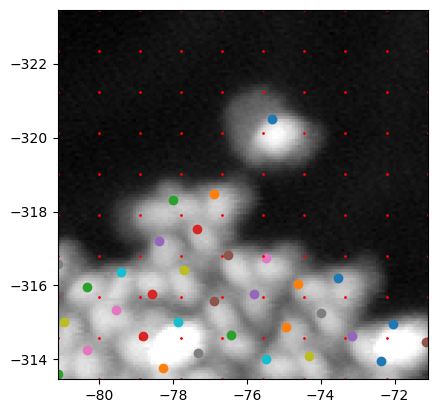

In [ ]:
x_nm=-76.106
y_nm=-323.461
len_nm=10
pixel=256
selected_points=[]
selected_points.append([data_blob.x[0], data_blob.y[0]])
plt.scatter(x_nm-len_nm/2+len_nm/pixel*data_blob.x[0], y_nm+len_nm/pixel*data_blob.y[0])
# plt.scatter(data.x, data.y)
for i in tqdm(range(len(data_blob))):
    selected_points_array=np.array(selected_points)
    if np.sqrt((data_blob.x[i]-selected_points_array[:, 0])**2+(data_blob.y[i]-selected_points_array[:, 1])**2).min()*len_nm/pixel>1:
        selected_points.append([data_blob.x[i], data_blob.y[i]])
        plt.scatter(x_nm-len_nm/2+len_nm/pixel*data_blob.x[i], y_nm+len_nm/pixel*data_blob.y[i])

xv, yv = np.meshgrid(np.linspace(x_nm-len_nm/2, x_nm+len_nm/2, 10), np.linspace(y_nm, y_nm+len_nm, 10))        
# plt.imshow(img2, extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm+len_nm, y_nm])
plt.scatter(xv, yv, c='r', s=1)

plt.imshow(img_10nm, extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm+len_nm, y_nm])
plt.xlim(x_nm-len_nm/2, x_nm+len_nm/2)
plt.ylim(y_nm+len_nm, y_nm)

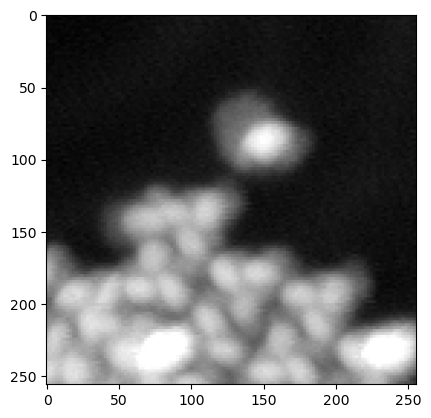

In [ ]:
plt.imshow(img_10nm)

In [ ]:
detect_mols=np.where(img_10nm>180)
for i in range(len(detect_mols[0])):
    # plt.imshow(edges, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    plt.imshow(img_10nm, extent=[x_nm-10/2, x_nm+10/2, y_nm+10, y_nm])
    plt.scatter(x_nm-10/2+detect_mols[1][i]*10/128, y_nm+detect_mols[0][i]*10/128, s=1, c='r')

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x00000264EE67D280> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000264FA911160> (for post_execute):


KeyboardInterrupt: 

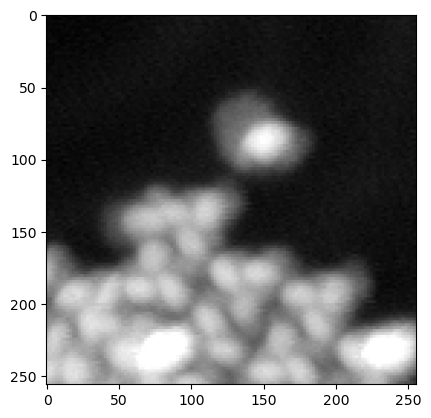

In [ ]:
plt.imshow(img_10nm)

In [ ]:
img=cv2.imread('large_image.png') 
edges=image_detect_edges(img)

In [ ]:
img.shape

(128, 128, 3)

In [ ]:
x_nm

1.7021236419677734

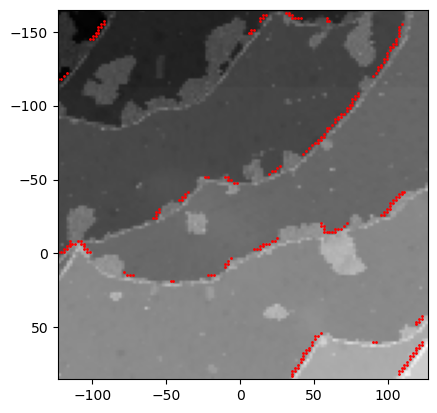

In [ ]:
edges_points=np.where(edges>0)
for i in range(len(edges_points[0])):
    # plt.imshow(edges, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    plt.imshow(img, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
    plt.scatter(x_nm-250/2+edges_points[1][i]*250/128, y_nm+edges_points[0][i]*250/128, s=1, c='r')

In [ ]:
edges_points

(array([  1,   1,   2,   2,   2,   2,   3,   3,   3,   3,   3,   3,   3,
          4,   4,   4,   4,   5,   5,   5,   6,   6,   6,   7,   7,   7,
          7,   8,   8,   8,   8,   8,   9,   9,   9,  10,  10,  10,  11,
         12,  12,  13,  13,  14,  15,  16,  17,  17,  18,  19,  20,  20,
         21,  22,  22,  23,  23,  24,  24,  29,  30,  30,  31,  31,  32,
         33,  33,  34,  34,  35,  36,  36,  37,  37,  38,  38,  39,  40,
         41,  41,  42,  43,  44,  44,  45,  45,  46,  46,  47,  48,  49,
         50,  54,  55,  56,  56,  57,  58,  58,  58,  58,  59,  59,  60,
         60,  63,  63,  63,  64,  64,  64,  65,  65,  65,  65,  66,  66,
         66,  66,  67,  67,  68,  69,  69,  69,  70,  70,  70,  70,  71,
         71,  71,  72,  72,  74,  74,  75,  75,  75,  76,  76,  76,  76,
         77,  77,  77,  77,  77,  79,  80,  80,  80,  80,  80,  81,  81,
         81,  81,  81,  81,  81,  81,  82,  82,  82,  82,  82,  83,  83,
         83,  83,  83,  83,  83,  84,  84,  84,  84

In [ ]:

data ={'x': edges_points[1], 'y': edges_points[0]}
data=pd.DataFrame(data)
data=data.drop_duplicates(ignore_index=True)
# data.loc[:, 'dist']=np.sqrt((data.x-147)**2+(data.y-141)**2)
# data=data.sort_values(by='dist', ascending=False, ignore_index=True)

In [ ]:
scan_1=env.createc_controller.stm.scanstart()

In [ ]:
def select_points(img, edges=False, dist_limit=1, x_nm=None, y_nm=None, len_nm=None, pixel=256, dist_thres=1):
    '''detect edges for large image (such as 250 nm) and dectect blobs for small image (such as 10 nm)''' 
    if (x_nm is None) or (y_nm is None):
        x_nm, y_nm = env.createc_controller.get_offset_nm()
    if len_nm is None:
        len_nm = env.createc_controller.im_size_nm

    plt.imshow(img, extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm+len_nm, y_nm])
    
    if edges:
        edges_img=image_detect_edges(img)
        detect_mols=np.where(edges_img>0)
    else:
        detect_mols=np.where(img>180)

    
    data_mols ={'x': detect_mols[1], 'y': detect_mols[0]}
    data_mols=pd.DataFrame(data_mols)
    data_mols=data_mols.drop_duplicates(ignore_index=True)

    selected_points=[]
    selected_points.append([data_mols.x[0], data_mols.y[0]])
    plt.scatter(x_nm-len_nm/2+len_nm/pixel*data_mols.x[0], y_nm+len_nm/pixel*data_mols.y[0])
    for i in tqdm(range(len(data_mols))):
        selected_points_array=np.array(selected_points)
        if np.sqrt((data_mols.x[i]-selected_points_array[:, 0])**2+(data_mols.y[i]-selected_points_array[:, 1])**2).min()*len_nm/pixel>dist_limit:
            selected_points.append([data_mols.x[i], data_mols.y[i]])
            plt.scatter(x_nm-len_nm/2+len_nm/pixel*data_mols.x[i], y_nm+len_nm/pixel*data_mols.y[i])


    plt.xlim(x_nm-len_nm/2, x_nm+len_nm/2)
    plt.ylim(y_nm+len_nm, y_nm)
    
    return selected_points

In [ ]:
img=cv2.imread('img_50_new.jpeg')

In [ ]:
img.shape

(256, 256, 3)

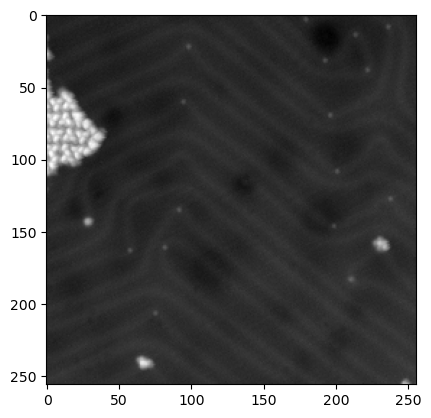

In [ ]:
plt.imshow(img)

In [ ]:
img.shape

AttributeError: 'NoneType' object has no attribute 'shape'

  0%|          | 0/542 [00:00<?, ?it/s]

100%|██████████| 542/542 [00:00<00:00, 13943.54it/s]


[[1, 23],
 [1, 44],
 [13, 52],
 [3, 54],
 [20, 60],
 [4, 64],
 [14, 69],
 [25, 69],
 [2, 74],
 [32, 77],
 [16, 79],
 [4, 84],
 [39, 85],
 [26, 86],
 [13, 90],
 [33, 94],
 [1, 96],
 [20, 98],
 [10, 101],
 [2, 110],
 [27, 141],
 [229, 154],
 [236, 162],
 [64, 237],
 [247, 252]]

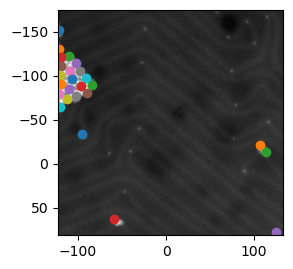

In [ ]:
plt.subplot(1,2,1)
select_points(img, x_nm=5.17, y_nm=-174.690, len_nm=256, dist_limit=10, edges=True, pixel=256)
# plt.subplot(1,2,2)
# select_points(img_10nm)

  0%|          | 0/10330 [00:00<?, ?it/s]

100%|██████████| 10330/10330 [00:00<00:00, 49591.17it/s]


[[148, 76],
 [108, 128],
 [80, 132],
 [96, 152],
 [70, 160],
 [118, 170],
 [144, 172],
 [0, 176],
 [87, 180],
 [44, 182],
 [194, 186],
 [166, 190],
 [20, 192],
 [65, 197],
 [136, 197],
 [108, 202],
 [40, 208],
 [182, 210],
 [4, 216],
 [83, 216],
 [232, 218],
 [158, 220],
 [120, 225],
 [59, 226],
 [204, 226],
 [255, 230],
 [20, 236],
 [97, 238],
 [174, 240],
 [144, 242],
 [224, 243],
 [73, 248],
 [0, 252]]

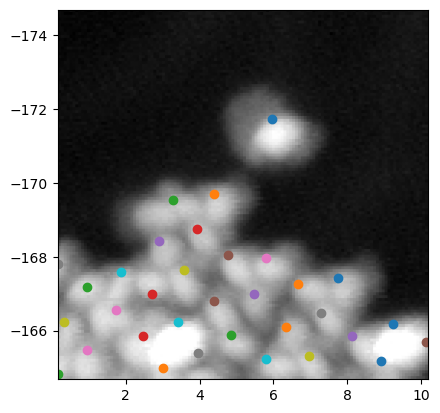

In [ ]:
select_points(img_10nm)

(-73.46100000000001, -323.461)

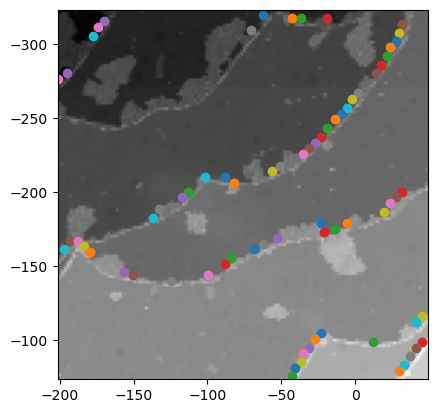

In [ ]:
x_nm=-76.106
y_nm=-323.461
len_nm=250
pixel=128
selected_points=[]
selected_points.append([data.x[0], data.y[0]])
# plt.scatter(data.x, data.y)
for i in range(len(data)):
    selected_points_array=np.array(selected_points)
    if np.sqrt((data.x[i]-selected_points_array[:, 0])**2+(data.y[i]-selected_points_array[:, 1])**2).min()*len_nm/pixel>5:
        selected_points.append([data.x[i], data.y[i]])
        plt.scatter(x_nm-len_nm/2+len_nm/pixel*data.x[i], y_nm+len_nm/pixel*data.y[i])
        
# plt.imshow(img2, extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm+len_nm, y_nm])
# plt.scatter(xv, yv, c='r', s=1)

plt.imshow(img, extent=[x_nm-250/2, x_nm+250/2, y_nm+250, y_nm])
plt.xlim(x_nm-len_nm/2, x_nm+len_nm/2)
plt.ylim(y_nm+len_nm, y_nm)

In [ ]:
x_nm-len_nm/2+len_nm/pixel*data.x[0]

-44.855999999999995

In [ ]:
y_nm+len_nm/pixel*data.y[0]

-321.507875

In [ ]:
env.createc_controller.set_xy_nm([170, -100])
env.createc_controller.stm.scanstart()

In [ ]:
ref_x=147
ref_y=141
x_nm=-59.699
y_nm=-151.536
len_nm=50  # nm
init_len=1 # nm
move_len=5 # nm
check_points=[[data['x'][i], data['y'][i]] for i in range(len(data))]
check_points_full=[[data['x'][i], data['y'][i]] for i in range(len(data))]
scan_nm_small=10

move_points=[]
plt.imshow(img, extent=[x_nm-len_nm/2, x_nm+len_nm/2, y_nm+len_nm, y_nm])
plt.scatter(x_nm-len_nm/2+len_nm/256*data['x'], y_nm+len_nm/256*data['y'], s=1, c='b')
data_move_all=[]
tip_form_x=133
tip_form_y=-117
tip_len=120
tip_points=[]
tip_points.append([tip_form_x, tip_form_y])
tip_lat_all=[]
# for i in range(len(data)):
for i in range(13, len(data), 5):
# for i in range(3):
    x=x_nm-len_nm/2+len_nm/256*data['x'][i]
    y=y_nm+len_nm/256*data['y'][i]
    plt.scatter([x], [y], s=1, c='r')

    check_points.remove([data['x'][i], data['y'][i]])
    for epoch in range(5):
        tip_start_x=x+init_len*(np.random.rand()*2-1)
        tip_start_y=y+init_len*(np.random.rand()*2-1)
        tip_end_x=tip_start_x+move_len*(np.random.rand()*2-1)
        tip_end_y=tip_start_y+move_len*(np.random.rand()*2-1)
        check_points_array=np.array(check_points)

        for find_epoch in range(50):
            if np.sqrt((check_points_array[:, 0]-tip_end_x)**2+(check_points_array[:, 1]-tip_end_y)**2).min()<2 or np.sqrt((tip_start_x-tip_end_x)**2-(tip_start_y-tip_end_y)**2)<1.5  or np.sqrt((x-tip_end_x)**2+(y-tip_end_y)**2)>scan_nm_small/2:
                tip_end_x=tip_start_x+move_len*(np.random.rand()*2-1)
                tip_end_y=tip_start_y+move_len*(np.random.rand()*2-1)
            else:
                if find_epoch==49:
                    break
                else:
                    pass    

        env.createc_controller.offset_nm = np.array([x, y-scan_nm_small/2])
        env.createc_controller.im_size_nm= scan_nm_small
        scan_data=env.createc_controller.scan_image()
        plt.imsave('images_move_before/image_forward_%s_%s.png' % (i, epoch), scan_data[0])
        plt.imsave('images_move_before/image_backward_%s_%s.png' % (i, epoch), scan_data[1])
        plt.imsave('images_move_before/image_for_back_%s_%s.png' % (i, epoch), (scan_data[0]+scan_data[1])/2)

        check_points.append([tip_end_x, tip_end_y])
        check_points_full.append([tip_end_x, tip_end_y])
        move_points.append([tip_end_x, tip_end_y])
        plt.scatter([tip_start_x], [tip_start_y], s=1, c='r')
        print(x, y-scan_nm_small/2, tip_start_x, tip_start_y, tip_end_x, tip_end_x)
        data_move=env.createc_controller.lat_manipulation(tip_start_x, tip_start_y, tip_end_x, tip_end_y, 32, 1000, np.array([x, y-scan_nm_small/2]), scan_nm_small)
        tip_lat_all.append([i, epoch, tip_start_x, tip_start_y, tip_end_x, tip_end_y])
        data_move_all.append(data_move)
        env.createc_controller.offset_nm = np.array([x, y-scan_nm_small/2])
        env.createc_controller.im_size_nm= scan_nm_small
        scan_data=env.createc_controller.scan_image()
        plt.imsave('images_move_after/image_forward_%s_%s.png' % (i, epoch), scan_data[0])
        plt.imsave('images_move_after/image_backward_%s_%s.png' % (i, epoch), scan_data[1])
        plt.imsave('images_move_after/image_for_back_%s_%s.png' % (i, epoch), (scan_data[0]+scan_data[1])/2)
    

        if epoch==2:
            env.createc_controller.set_xy_nm([tip_form_x, tip_form_y-120/2])
            for j in range(2):
                tip_x=tip_form_x+120*np.random.rand()
                tip_y=tip_form_y+120*np.random.rand()
                check_tip_points_array=np.array(tip_points)
                while np.sqrt((check_tip_points_array[:, 0]-tip_x)**2+(check_tip_points_array[:, 1]-tip_y)**2).min()<3.5:
                    tip_x=tip_form_x+120*np.random.rand()
                    tip_y=tip_form_y+120*np.random.rand()
                up_limit=35
                down_limit=10
                tip_z_approach=down_limit+np.random.rand()*(up_limit-down_limit)
                env.createc_controller.tip_form(tip_z_approach, tip_x, tip_y)  
                tip_points.append([tip_x, tip_y])

    check_points.append([data['x'][i], data['y'][i]])  # restore all points in data plus tip_end_points

with open("data_move_1004_14.pkl", "wb") as fp:   #Pickling
    pickle.dump(data_move_all, fp)
plt.xlim(x_nm-len_nm/2, x_nm+len_nm/2)
plt.ylim(y_nm, y_nm+len_nm)

### Create a sac_agent object

In [ ]:
#TODO
batch_size= 64 #Set minibatch size
LEARNING_RATE = 0.0003 #Set learning rate

#Set the action space range
ACTION_SPACE = namedtuple('ACTION_SPACE', ['high', 'low'])
action_space = ACTION_SPACE(high = torch.tensor([1,1,1,1]), low = torch.tensor([-1,-1,-1,1/2]))

#Initialize the soft actor-critic agent
alpha = 1.0
agent = sac_agent(num_inputs = 4, num_actions = 4, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=alpha)

### Create a HerReplayMemory object
Here we use the hindsight experience replay with the 'future' strategy to sample goals

In [ ]:
#TODO
replay_size=1000000 #Set memory size

memory = HerReplayMemory(replay_size, env, strategy = 'future')

In [ ]:
memory.n_sampled_goal

2

### Create a Episode_Memory object
The episode memory class is used to store all the relavant information in each training episode, including the STM images, state, action, reward, etc.

In [ ]:
episode_memory = Episode_Memory()
#TODO
#Set the folder name to store training data and neural network weight
folder_name =  'C:/Users/wun2/github/test_nian'
#folder_name =  'C:/LocalUserData/User-data/phys-asp-lab/nian_auto_spm/test_nian'

### Set the hyperparameters for Emphasize Recent Experience replay

In [ ]:
c_k_min = 500
# eta = 0.994
max_ep_len = max_len

### Create empty lists for logging performances

In [ ]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

# Define the training function

In [ ]:
def sac_train(max_steps = max_len, num_episodes = 50, episode_start = 0):
    """
    Collect training data and train the RL agent

    Parameters
    ----------
    max_steps: int
            maximum steps in an episode
            
    num_episodes: int
            Train for this many episodes
    
    episode_start: int
            Index to use for the starting episode

    Returns
    -------
    None : None
    """
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset(update_conv_net=False)
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        
        for step in range(max_steps):
            action = agent.select_action(state)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            print('step:', step,'reward', reward, 'precision:', env.dist_destination)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                print('Episode reward:', episode_reward)
                break
            else:                
                state=next_state
             
        if (len(memory)>batch_size):
            episode_K = int(episode_steps)
            for k in range(episode_K):
                c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
                agent.update_parameters(memory, batch_size, c_k)
        
        episode_rewards.append(episode_reward)
        alphas.append(agent.alpha.item())
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                      avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
            
        if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))
            torch.save(env.atom_move_detector.conv.state_dict(), '{}/_atom_move_detector_conv_{}.pth'.format(folder_name))

In [ ]:
max_steps = 5
num_episodes = 50
episode_start = 0

In [ ]:
done_dect_atom=False


In [ ]:
# find a section to condition tip
start_crash_hole=0
approach_z=2

def tip_cond_area(center_x=0, center_y=0, approach_area_length=800, cond_area_length=200, margin=20):
    cond_area_center_x, cond_area_center_y=center_x-approach_area_length+cond_area_length+margin, center_y-approach_area_length+cond_area_center_y+margin
    return cond_area_center_x, cond_area_center_y, cond_area_length

env.default_max_radius_cellsize(cellsize=20, max_radius=200)
points=env.computeLocationIDs()
cond_area_center_x, cond_area_center_y, cond_area_length=tip_cond_area()

env.createc_controller.ramp_bias_mV(-1.2)
env.createc_controller.tip_form(approach_z, cond_area_center_x+points[start_crash_hole][0]*cellsize,cond_area_center_y+points[start_crash_hole][1]*cellsize)
print(env.createc_controller.im_size_nm)
start_crash_hole=start_crash_hole

In [ ]:
start_x = 0
start_y = 0
tip_x = 0
tip_y = 0
check_similarity=None
check_similarity.append([tip_x, tip_y])
radius = 35
upper_limit_move=400
env.max_radius=150

image_forward = info['img_info']['img_forward']
image_backward =info['img_info']['img_backward']


# dectect atoms
isAtom = False

# debris
debris_thres = 6
DebresCounter = 0
noDebris = False

# Crash dectected
crash_thres = 1e-25 
approach_z = 4
noCrash = False

while not isAtom or not noDebris or not noCrash:
    
    # detect atoms
    atom_forward = blob_detection(info[img_forward])[0]

    if len(atom_forward)>0:
        isAtom = True

    # detect debris
    noDebris =  ((np.max(image_forward) - np.min(image_forward)) < debris_thres) 
    
    # dectect crash
    noCrash = (np.max(img_forward)-np.min(img_forward) )< crash_thres and (np.mean(img_forward)>0)
    
    if isAtom and noDebris and noCrash:
        continue                
    else:
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=start_x, initial_y=start_y, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        if tip_x==None:
            tip_x, tip_y=check_similarity[-1][0], check_similarity[-1][1]
            image=env.set_newtip_pos(tip_x, tip_y)
            image_forward, image_backward =image[0], image[1]
            radius=radius*2
            env.max_radius=env.max_radius*2
            upper_limit_move=upper_limit_move+20000
        else:
            radius=35
            upper_limit_move=400
            env.max_radius=150
                
    
            
            
    check_similarity.append([tip_x, tip_y])        
    if radius>280:
        print('there is no section satisfying the demand within radius of 280 nm')
        break

    

        
        
    
    



# tip condition section

In [ ]:
center_x=0
center_y=0
approach_area_length=800
def tip_cond_area(center_x=0, center_y=0, approach_area_length=800, cond_area_length=200, margin=20):
    cond_area_center_x, cond_area_center_y=center_x-approach_area_length+cond_area_length+margin, center_y-approach_area_length+cond_area_center_y+margin
    return cond_area_center_x, cond_area_center_y, cond_area_length


    
    

# Condition probe

In [ ]:
env.createc_controller.stm.setparam('TipForm_Volt', -3) # Set the bias voltage for the atom manipulation(unit V)

env.createc_controller.stm.setparam('TipForm_Z', 0.0) # Set the z position for the atom manipulation(unit angstrom)

env.createc_controller.stm.setparam('Tip_Delay', 0.4915) # Set the delay time for the atom manipulation(unit s)
env.createc_controller.stm.setparam('Tip_Latddx', 833) # Set the lateral ddx for the atom manipulation(unit angstrom/ms^2)
env.createc_controller.stm.setparam('Tip_LatDelay', 20) # Set the lateral delay for the atom manipulation(unit ms)
env.createc_controller.stm.setparam('Tip_Gain', 6) # Set the gain for the atom manipulation(unit 1)
env.createc_controller.stm.setparam('TipForm_Zoffset', 0.0) # Set the z offset for the atom manipulation(unit angstrom)



In [ ]:
tip_condition_actions={'stall': [0, 0],
                      'soft pulse pos':[0, 2.5],
                      'medium pulse pos': [0, 4.0],
                      'soft pulse neg': [0 , -2.5], 
                      'medium pulse neg': [0, -4],
                      'strong pulse neg': [0, -8],
                      'very soft dip': [0, -8],
                      'soft dip 1': [-0.80, 0.02],
                      'soft dip 2': [-1.2, 0.02],
                      'soft dip 3': [-1.8, 0.02],
                      'medium soft': [-2.5, 0.02],
                      'strong dip': [-5.0, 0.02]
                      }


In [ ]:
num_no_done = 0
episode_start=0
max_episode = 10
num_episodes=50
for i_episode in range(episode_start,episode_start+num_episodes):
    print('Episode:', i_episode)
    episode_reward, episode_steps = 0, 0
    done = False
    print('offffset0000',env.offset_nm)
    state, info = env.reset(update_conv_net=False)
    print(state, info)
    
 # detect atoms   

#  no debris

# crash or no probe-atom contact
    
    
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
               env.template_nm, env.template_wh)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    print('offffset1111',env.offset_nm)
    


    for step in range(max_steps):
        action = agent.select_action(state)
        old_atom_nm = env.atom_absolute_nm
        print('offffset2222',env.offset_nm)
        next_state, reward, done, info = env.step(action)
        print('offffset3333',env.offset_nm)
        episode_steps+=1
        episode_reward+=reward
        mask = float(not done)
        memory.push(state,action,reward,next_state,mask)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        print(info)
        show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                    env.atom_absolute_nm, env.atom_start_absolute_nm, 
                    env.destination_absolute_nm, action[4]*env.max_mvolt, 
                    action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                    env.template_nm, env.template_wh)
        print('step:', step,'reward', reward, 'precision:', env.dist_destination)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
            episode_memory.save_memory(folder_name)
            print('Episode reward:', episode_reward)
            break
        else:                
            state=next_state
            
    # if manipulation fails N times, adjust tip conditioning
    
    


        

    if (len(memory)>batch_size):
        episode_K = int(episode_steps)
        for k in range(episode_K):
            c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
            agent.update_parameters(memory, batch_size, c_k)

In [ ]:
env.createc_controller.stm.scanstop()

### Define the training function

In [ ]:
env.dist_destination=0.3934795995776328